In [1]:
suppressMessages({
    library(tidyverse)
    library(ComplexHeatmap)
    library(circlize)
    library(RColorBrewer)
    library(viridisLite)
    library(grid)
    library(viridis)
    library(repr)
    library(openxlsx)
})

setwd("/data/wangrr/Analysis/epiRNA/workdir2/filter")

Warning message:
“package ‘ggplot2’ was built under R version 4.4.3”
Warning message:
“package ‘tibble’ was built under R version 4.4.3”


Warning message:
“package ‘purrr’ was built under R version 4.4.2”
Warning message:
“package ‘lubridate’ was built under R version 4.4.2”
Warning message:
“package ‘ComplexHeatmap’ was built under R version 4.4.2”
Warning message:
“package ‘circlize’ was built under R version 4.4.3”


In [2]:
q_thresh <- 0.1
score_cap <- 10
max_genes_plot <- 80
max_query_plot <- 100

cns_palette <- c(
  "#0B775E", "#0072B2", "#56B4E9", "#009E73", "#F0E442",
  "#E69F00", "#D55E00", "#CC79A7", "#8E44AD", "#2C3E50"
)

In [3]:
input_csv <- "window_counted_tomtom_RBP_hits.csv"

df <- read_csv(input_csv, col_types = cols(.default = "c"))
names(df) <- names(df) %>% str_replace_all("\\s+", "_") %>% str_replace_all("-", "_")
numcols <- c("p_value", "E_value", "q_value", "Overlap", "Optimal_offset")
for (nc in intersect(numcols, names(df))) {
  df[[nc]] <- as.numeric(df[[nc]])
}

df_filtered <- df %>%
  filter(!is.na(q_value)) %>%
  filter(q_value <= q_thresh)

cat("Total rows:", nrow(df), "Filtered significant rows:", nrow(df_filtered), "\n")

Total rows: 55952 Filtered significant rows: 2778 


In [4]:
df_best <- df_filtered %>%
  arrange(Query_ID, Name, q_value) %>%
  group_by(Query_ID, Name) %>%
  slice(1) %>%
  ungroup() %>%
  mutate(score = -log10(pmax(q_value, 1e-300)),
         score_cap = pmin(score, score_cap))

mat_plot <- df_best %>%
  select(Query_ID, Name, score) %>%
  pivot_wider(names_from = Name, values_from = score) %>%
  column_to_rownames("Query_ID") %>%
  as.matrix()

mat_plot[is.na(mat_plot)] <- 0
mat_clust <- mat_plot

In [5]:
dim(mat_plot)

[1] 180 428

In [6]:
gene_meta <- df_best %>%
  select(Name, Type, Source, Organism) %>%
  distinct() %>%
  group_by(Name) %>%
  summarize(
    Source = paste(unique(na.omit(Source)), collapse = ";"),
    Organism = paste(unique(na.omit(Organism)), collapse = ";"),
    .groups = "drop"
  ) %>% column_to_rownames("Name")

missing <- setdiff(colnames(mat_plot), rownames(gene_meta))
if (length(missing) > 0) {
  gene_meta[missing, ] <- NA
}

In [7]:
# use first token when multiple values; convert to factor with stable levels
first_token <- function(x) sapply(strsplit(as.character(x), ";"), function(z) if (length(z)==0) NA else z[1])
Source1 <- factor(first_token(gene_meta[colnames(mat_plot),"Source"]), exclude = NULL)
Species1 <- factor(first_token(gene_meta[colnames(mat_plot),"Organism"]), exclude = NULL)

# color maps
source_cols <- setNames(brewer.pal(length(levels(Source1)), "Dark2"), levels(Source1))
species_cols <- setNames(viridis(length(levels(Species1))), levels(Species1))

In [29]:
col_fun <- colorRamp2(
  c(0, 0.5, 1, 2, 3, 5),
  c("#F8F8F8", "#9ECAE1", "#6BAED6", "#4292C6", "#2171B5", "#084594") 
)

col_fun <- colorRampPalette(brewer.pal(5, "Reds"))(50)
col_ha <- HeatmapAnnotation(
  Source = Source1,
  Species = Species1,
  col = list(Source = source_cols, Species = species_cols),
  show_annotation_name = TRUE,
  annotation_name_side = "left"
)

ht <- Heatmap(
  mat_plot,
  name = "score",
  col = col_fun,
  na_col = "#F0F0F0",
  show_row_names = FALSE,
  show_column_names = FALSE,
  
  cluster_rows = F,
  cluster_columns = F,
  top_annotation = col_ha,
  column_title = "RBPs (428 targets)",
  row_title = "Query motifs (180 PWMs)",

  heatmap_legend_param = list(
    title = "-log10(q)",
    at = c(0, 1, 2, 3),
    labels = c("0", "1", "2", "3")
  ),

  border = TRUE,
  width = unit(12, "cm"),
  height = unit(6, "cm")
)

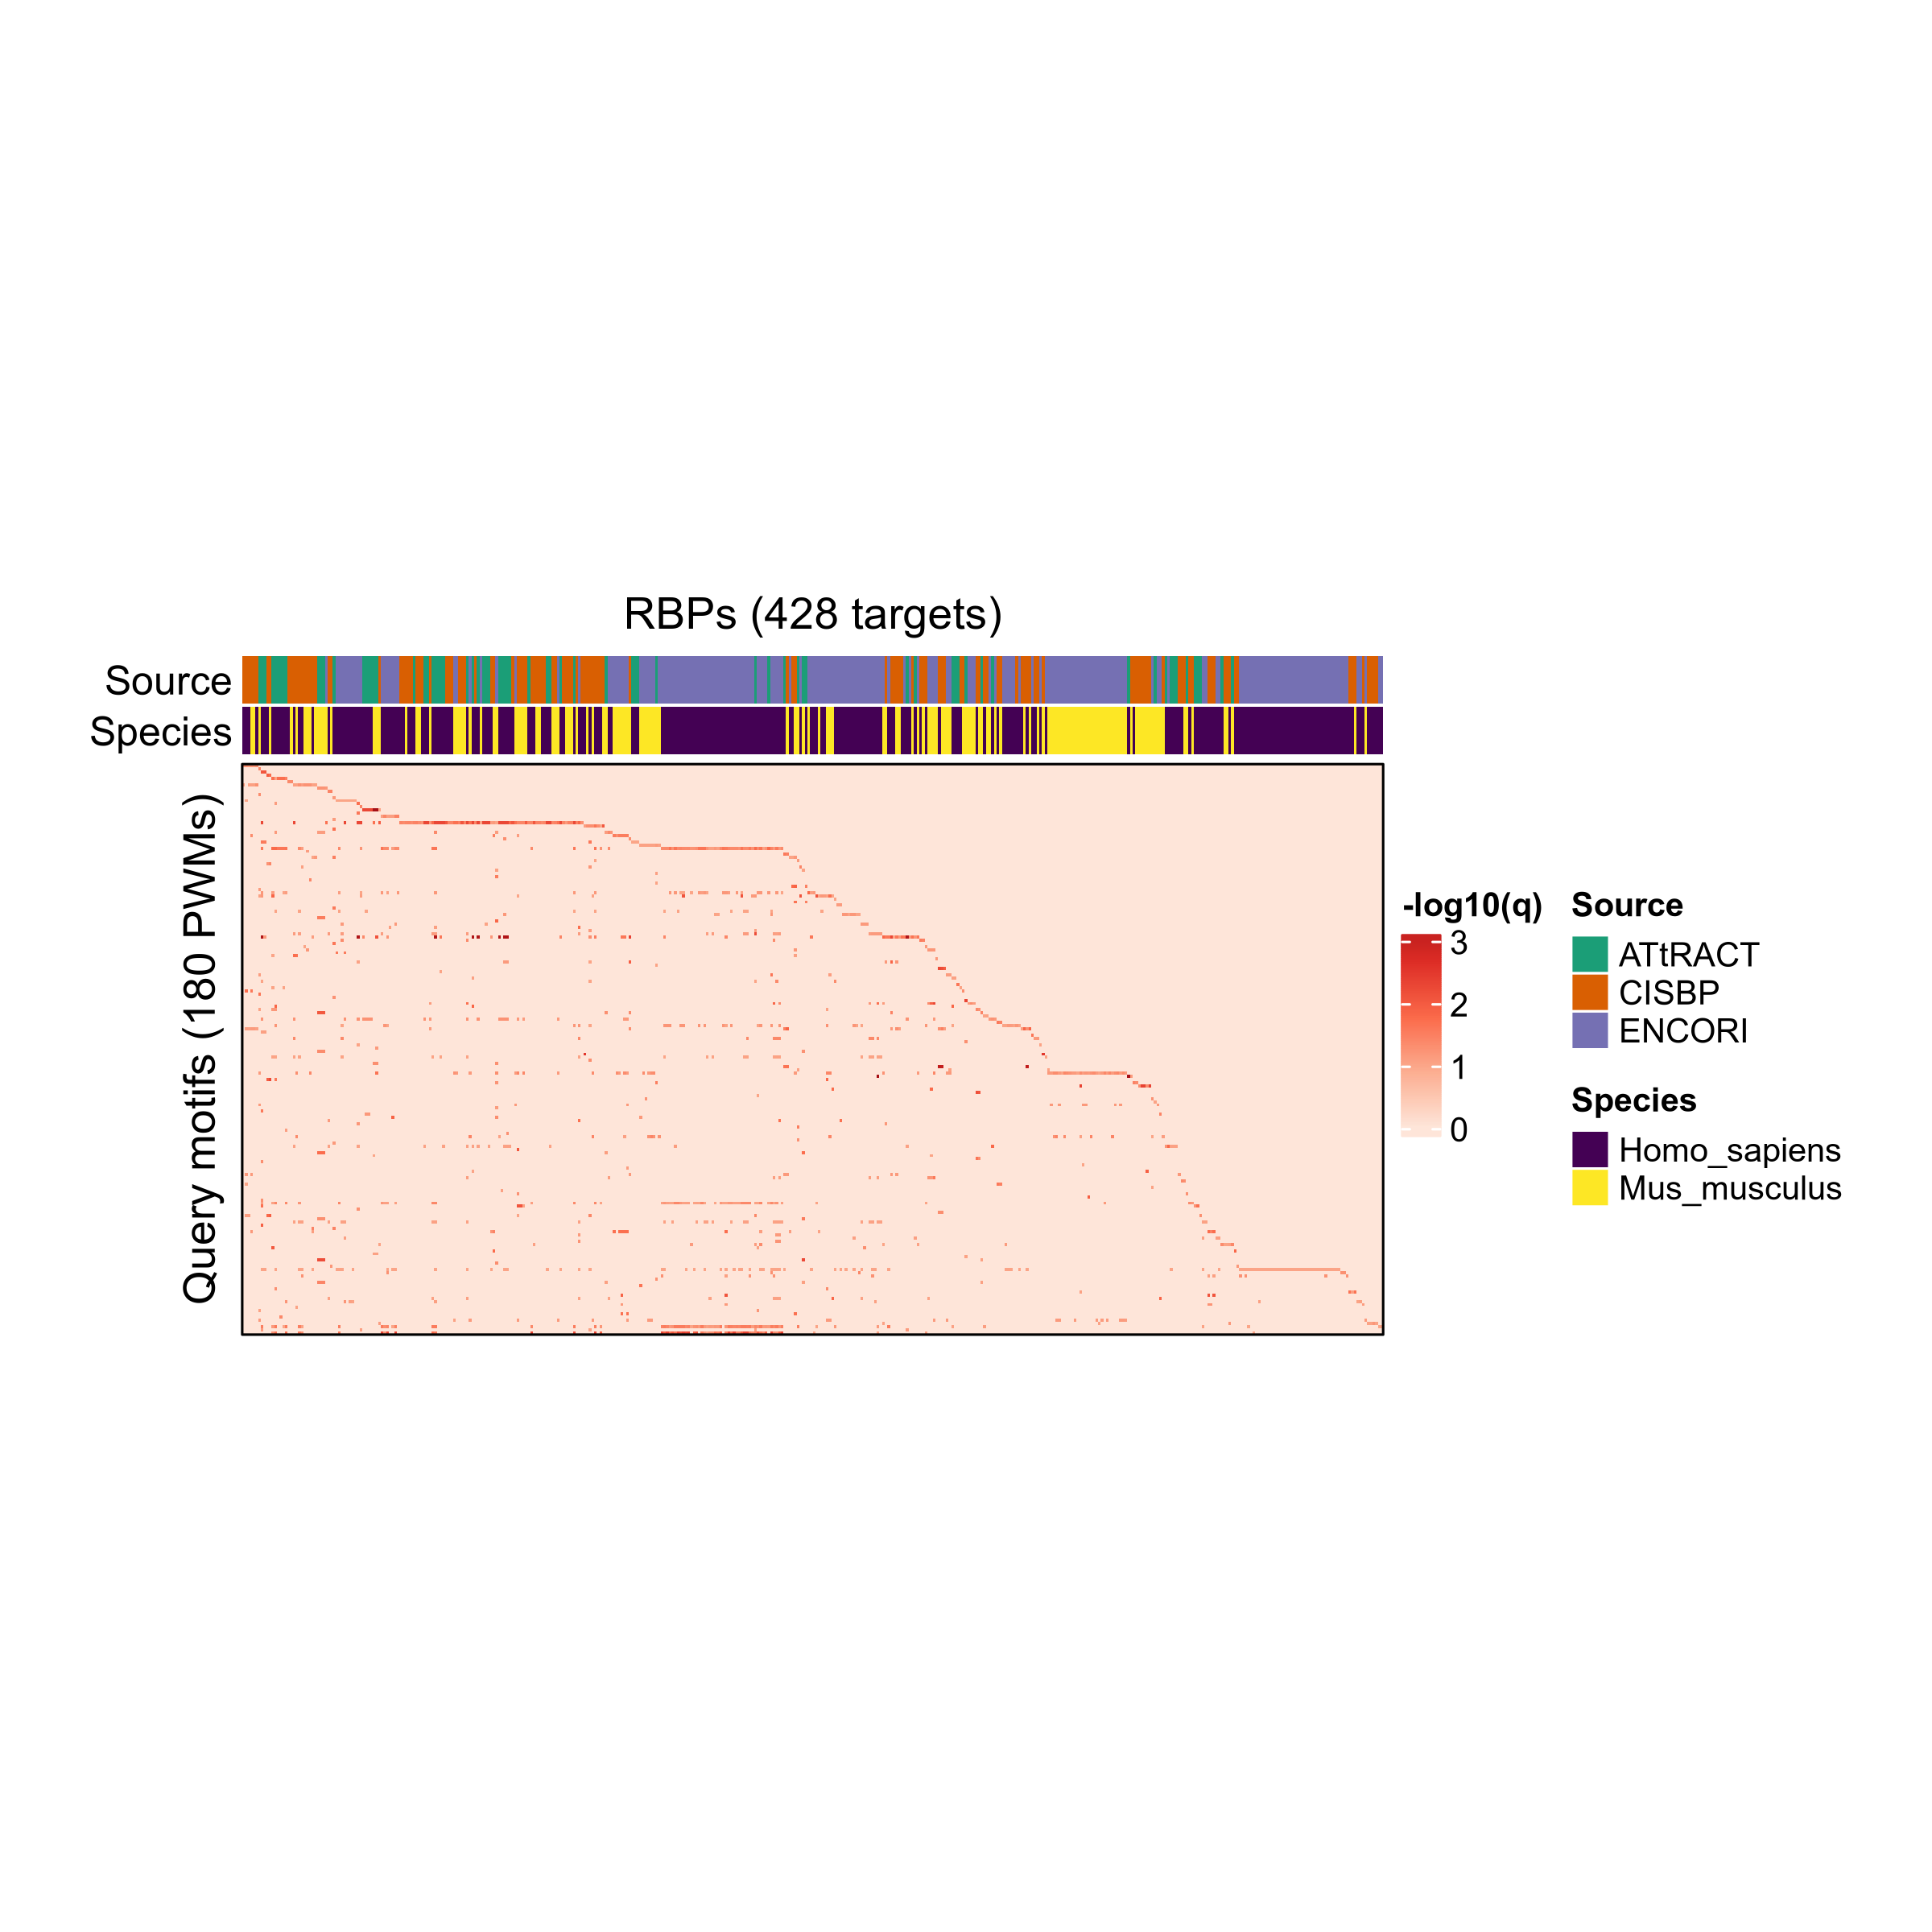

In [30]:
options(repr.plot.width=8, repr.plot.height=8, repr.plot.res=300)
print(ht)

In [33]:
top_genes <- df_best %>%
  count(Name, name = "Num_Queries") %>%
  arrange(desc(Num_Queries)) %>%
  head(30)

p2 <- ggplot(top_genes, aes(x = reorder(Name, Num_Queries), y = Num_Queries)) +
  geom_col(fill = cns_palette[3], alpha = 0.9, width = 0.7) +
  geom_text(aes(label = Num_Queries), hjust = -0.2, size = 3) +
  coord_flip() +
  labs(
    title = "",
    x = "Gene",
    y = "Number of Queries Matched"
  ) +
  theme_minimal(base_size = 10) +
  theme(
    plot.title = element_text(face = "bold", hjust = 0.5),
    axis.text.y = element_text(size = 9,color = "black"),
    axis.title.x = element_text(size = 12),
    axis.title.y = element_text(size = 12),
    panel.grid.minor = element_blank()
  ) +
  scale_y_continuous(expand = expansion(mult = c(0, 0.1)))

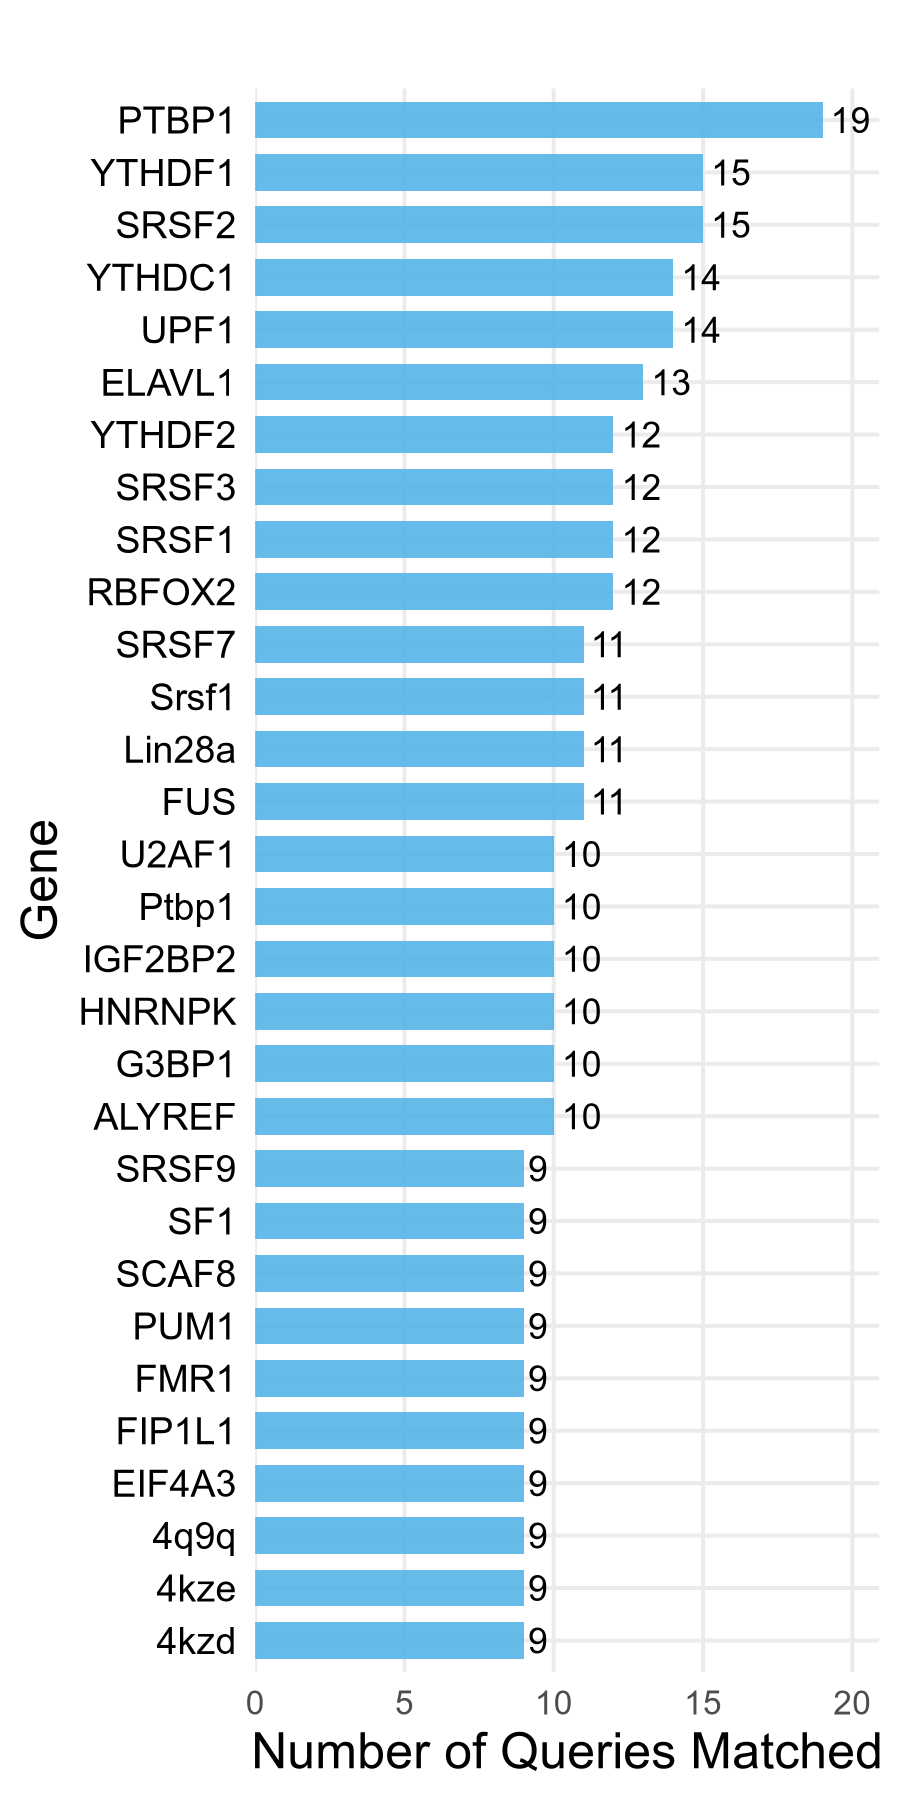

In [34]:
options(repr.plot.width=3, repr.plot.height=6)
p2

In [73]:
df_filtered %>%
    filter(Name == "RBFOX2") %>%
    arrange(q_value) %>%
    head(10)

Query_ID,Target_ID,Optimal_offset,p_value,E_value,q_value,Overlap,Query_consensus,Target_consensus,Orientation,Name,Organism,Source,Type
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
filter_window_width17_60,CISBP_M00780_2.00|RBFOX2|Homo_sapiens,-6,3.22577e-05,0.0175482,0.00803066,5,CUAGUGGCAUGGUGAUG,GCAUG,+,RBFOX2,Homo_sapiens,CISBP,RBP
filter_window_width17_471,CISBP_M00780_2.00|RBFOX2|Homo_sapiens,-3,1.07441e-04,0.0584477,0.01919750,5,CGUGCAUGUGGUGAGAU,GCAUG,+,RBFOX2,Homo_sapiens,CISBP,RBP
filter_window_width17_164,ENCORI_SBDH1801_1|RBFOX2|Homo_sapiens,-1,1.84866e-04,0.9001120,0.02723640,6,AGAAGAAUCACUUGAGC,GAAGAA,+,RBFOX2,Homo_sapiens,ENCORI,RBP
filter_window_width17_95,ENCORI_SBDH1802_1|RBFOX2|Homo_sapiens,-1,5.05186e-04,2.4597500,0.02922450,6,CUGAAGACAACUUCAUU,UGAAGA,+,RBFOX2,Homo_sapiens,ENCORI,RBP
filter_window_width17_224,ENCORI_SBDH270_3|RBFOX2|Homo_sapiens,-3,6.30183e-05,0.3068360,0.03793220,6,UCCCCCCCCUACCCCAC,CCCCCC,+,RBFOX2,Homo_sapiens,ENCORI,RBP
filter_window_width17_224,ENCORI_SBDH271_3|RBFOX2|Homo_sapiens,-3,1.11493e-04,0.5428570,0.04129840,6,UCCCCCCCCUACCCCAC,CCCCCC,+,RBFOX2,Homo_sapiens,ENCORI,RBP
filter_window_width17_164,ENCORI_SBDH1802_1|RBFOX2|Homo_sapiens,0,9.91941e-04,4.8297600,0.04330160,6,AGAAGAAUCACUUGAGC,UGAAGA,+,RBFOX2,Homo_sapiens,ENCORI,RBP
filter_window_width17_471,ATtRACT_141|RBFOX2|Homo_sapiens,-2,6.49181e-04,0.7751220,0.05917160,6,CGUGCAUGUGGUGAGAU,UGCAUG,+,RBFOX2,Homo_sapiens,ATtRACT,RBP
filter_window_width17_471,ATtRACT_625|RBFOX2|Homo_sapiens,-2,6.49181e-04,0.7751220,0.05917160,6,CGUGCAUGUGGUGAGAU,UGCAUG,+,RBFOX2,Homo_sapiens,ATtRACT,RBP


In [54]:
print(df_filtered$Name %>% unique())

  [1] "PTBP1"           "RBM4"            "SF1"             "SRSF2"          
  [5] "HNRNPA1"         "HNRNPA2B1"       "RBM6"            "SRSF5"          
  [9] "RBM5"            "SRSF7"           "TIA1"            "SRSF3"          
 [13] "SRSF1"           "SRSF6"           "SRSF4"           "TRA2B"          
 [17] "HNRNPF"          "HNRNPH1"         "HNRNPH2"         "HNRNPH3"        
 [21] "ELAVL2"          "ELAVL4"          "TIAL1"           "ELAVL1"         
 [25] "HNRNPK"          "FUS"             "SYNCRIP"         "HNRNPU"         
 [29] "ELAVL3"          "NOVA1"           "SFPQ"            "KHDRBS1"        
 [33] "KHDRBS2"         "KHDRBS3"         "DDX19B"          "U2AF2"          
 [37] "DAZAP1"          "FMR1"            "HNRNPC"          "PCBP1"          
 [41] "PCBP2"           "NOVA2"           "EIF4A3"          "PPIE"           
 [45] "CPEB4"           "RALY"            "HNRNPCL1"        "CPEB1"          
 [49] "SRP19"           "SRP68"           "SRP54"           "TRA